## _Setup_ geral

 df_death : https://superset.plataformatarget.com.br/superset/dashboard/microdados/
 
 https://www.kaggle.com/ricardosaat/covid-19-sao-paulo-sp-brasil
 
 model SIR : https://github.com/AndresRuizCh/fit-data-covid19

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from scipy import interpolate, integrate
from scipy import optimize
import seaborn as sns

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as pyo
import plotly.graph_objs as go


In [2]:
# Algumas configurações para o matplotlib.
# %matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

# sns.set()

In [3]:

# Full history data from Brasil.IO with notification rate and estimated active cases
df_full = pd.read_csv('http://datasource.coronacidades.org/br/cities/cases/full')

#  Beds and ventilators data from DataSus/CNES
df_beds = pd.read_csv('http://datasource.coronacidades.org/br/cities/cnes')

# Óbitos detalhados
df_death = pd.read_csv('data/df_mortes.csv')

In [4]:
df_death = pd.read_csv('data/df_mortes.csv')

In [5]:
df_death[df_death['Município de Residência'] == 'João Pessoa']
df_death.drop('Município de Residência',axis=1,inplace=True)


In [6]:
df_beds[df_beds['city_name'] == 'João Pessoa']

,author_number_beds,author_number_icu_beds,author_number_ventilators,city_id,city_name,country_iso,country_name,data_last_refreshed,female,female-0-19,...,male-70-79,male-80>,number_beds,number_covid_icu_beds,number_icu_beds,number_ventilators,population,state_id,state_name,state_num_id
2657,DataSUS,DataSUS,DataSUS,2507507,João Pessoa,BR,Brasil,2020-08-29 06:09:09,NaN,NaN,...,NaN,NaN,1926,76,210,483,809015,PB,Paraíba,25


In [7]:
df_full.columns

Index(['active_cases', 'city_id', 'city_name', 'city_notification_place_type',
       'city_notification_rate', 'confirmed_cases', 'daily_cases', 'deaths',
       'epidemiological_week', 'estimated_population_2019', 'health_region_id',
       'health_region_name', 'health_region_notification_place_type',
       'health_region_notification_rate', 'infectious_period_cases', 'is_last',
       'is_repeated', 'last_available_confirmed_per_100k_inhabitants',
       'last_available_date', 'last_available_death_rate', 'last_updated',
       'new_deaths', 'notification_rate', 'order_for_place', 'place_type',
       'state_id', 'state_name', 'state_notification_rate', 'state_num_id',
       'data_last_refreshed'],
      dtype='object')

In [8]:
df_full.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609446 entries, 0 to 609445
Data columns (total 30 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   active_cases                                   609446 non-null  float64
 1   city_id                                        609446 non-null  int64  
 2   city_name                                      609446 non-null  object 
 3   city_notification_place_type                   605452 non-null  object 
 4   city_notification_rate                         297775 non-null  float64
 5   confirmed_cases                                609446 non-null  float64
 6   daily_cases                                    609446 non-null  float64
 7   deaths                                         609446 non-null  float64
 8   epidemiological_week                           609446 non-null  int64  
 9   estimated_population_2019            

In [9]:
df_jp = df_full[df_full['city_name'] == 'João Pessoa']
df_jp.info(verbose=True)
print(df_jp.head(10))
df_jp.columns
print(len(df_jp.columns))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 156884 to 157047
Data columns (total 30 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   active_cases                                   164 non-null    float64
 1   city_id                                        164 non-null    int64  
 2   city_name                                      164 non-null    object 
 3   city_notification_place_type                   145 non-null    object 
 4   city_notification_rate                         141 non-null    float64
 5   confirmed_cases                                164 non-null    float64
 6   daily_cases                                    164 non-null    float64
 7   deaths                                         164 non-null    float64
 8   epidemiological_week                           164 non-null    int64  
 9   estimated_population_2019                     

In [10]:
def dados_nulos(df):  
  """
  Traz alguns dados interessantes sobre os dados dos datasets.
  parâmetros:
   df : pd.DataFrame 
  returns: 
   pd.DataFrame contendo as informações comparativas
  """
  return pd.DataFrame({
      'dtype' : df.dtypes,
      'nulls': df.isna().sum(),
      'nulls(%)': df.isna().mean(),
      'nunique': df.nunique(),
      
  })
dados_nulos(df_jp)
dados_nulos(df_death)

,dtype,nulls,nulls(%),nunique
Método,object,1,0.000418,9
Inicio Sintomas,object,0,0.000000,157
Sexo,object,0,0.000000,2
Doenças preexistentes,object,0,0.000000,194
Idade,object,0,0.000000,98
Data do Óbito,object,0,0.000000,148


Já é possível descartar algumas colunas já que no caso desta análise, estamos tratando de uma única região e muitas dessas colunas possuem em todo o dataframe (df_jp) um único valor.

city_id 

city_name 

state_name

state_id

place type 

state_num_id

data_last_refreshed	

health_region_name

health_region_id

city_notification_place_type

In [11]:
cols_to_drop = ['city_id', 

'city_name',

'state_name',

'state_id',

'place_type', 

'state_num_id',

'data_last_refreshed',	

'health_region_name',

'health_region_id',

'estimated_population_2019',

'city_notification_place_type']

In [12]:
df_jp.drop(cols_to_drop,axis=1,inplace=True)

In [13]:
print(df_jp.columns)
print(len(df_jp.columns))

Index(['active_cases', 'city_notification_rate', 'confirmed_cases',
       'daily_cases', 'deaths', 'epidemiological_week',
       'health_region_notification_place_type',
       'health_region_notification_rate', 'infectious_period_cases', 'is_last',
       'is_repeated', 'last_available_confirmed_per_100k_inhabitants',
       'last_available_date', 'last_available_death_rate', 'last_updated',
       'new_deaths', 'notification_rate', 'order_for_place',
       'state_notification_rate'],
      dtype='object')
19


Por enquanto não irei dropar ou inputar algum dado nas colunas que possuem dados nulos. Apesar de haver um número significante (de 11 a 14% de dados nulos), ainda não sei se irei utilizar essas colunas, por isso, irei conservá-las desse modo.

In [14]:
df_jp['Date'] = pd.to_datetime(df_jp.last_available_date)
df_jp.set_index('Date', inplace = True)

In [15]:
death_rate = df_jp.last_available_death_rate.mean() # média da taxa de morte do coronavirus em João Pessoa, em porcentagem 

population_Jp = 809015.0

In [16]:
df_death['nova_idade'] = df_death['Idade'].apply(lambda x: x if (("dias") or ("ano")) not in str(x) else 1)
df_death.nova_idade = df_death.nova_idade.astype(str).astype(int)
df_death.drop('Idade',axis=1)
print(df_death.dtypes)

Método                   object
Inicio Sintomas          object
Sexo                     object
Doenças preexistentes    object
Idade                    object
Data do Óbito            object
nova_idade                int64
dtype: object


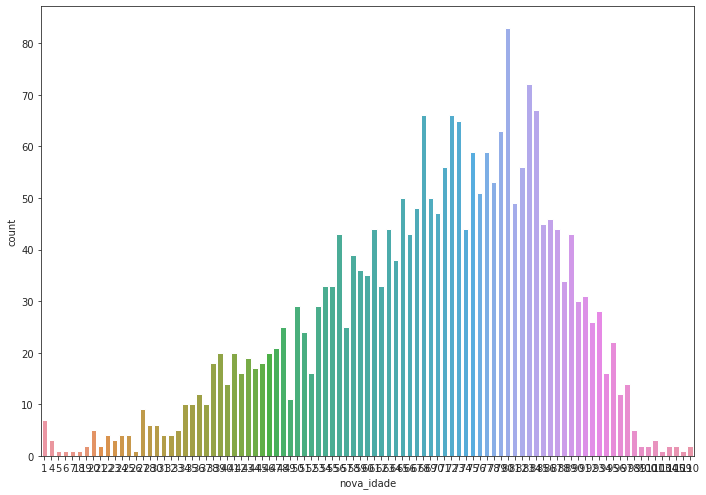

In [17]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.countplot(x='nova_idade', data=df_death);

In [18]:
print(df_death.nova_idade.max())
print(df_death.nova_idade.min())
print(df_death.nova_idade.mean())
# print(df_death['Doenças preexistentes'].nunique())
# df_death.astype(int)


110
1
68.8069368992896


In [19]:
df_death['Idade_Agrupada'] = pd.cut(df_death['nova_idade'], bins=[0, 10, 20, 30, 40, 50, 60, 70,80,90,100], labels=range(10)).ravel()

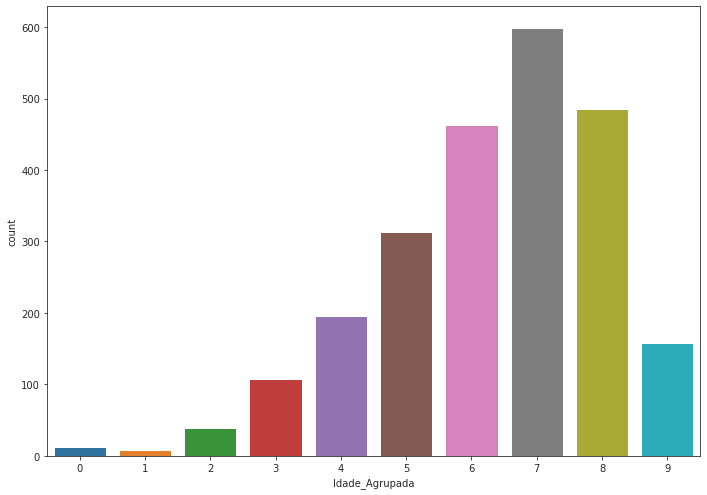

In [20]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.countplot(x='Idade_Agrupada', data=df_death);

# 0 : 0 - 10
# 1 : 10 - 20 
# ... 

In [21]:
df_death['Doenças preexistentes'].value_counts()
df_death.index

RangeIndex(start=0, stop=2393, step=1)

Códigos baseados no projeto no link Fit COVID-19 real data to SIR or Logistic models (https://github.com/AndresRuizCh/fit-data-covid19)

In [22]:
def logistic_model(x, a, b, c):
    """Uses Logistic Model (https://en.wikipedia.org/wiki/Logistic_regression) to fit the curve of infected
        individuals to a Logistic Curve f(x, a, b, c) = c / (1 + exp(-(x-b)/a))

        Args:
        - x : (float) Time to evaluate the infected curve
        - a, b, c : (float) Logistic Curve paramters
    """
    return c / (1 + np.exp(-(x - b) / a))


In [23]:
def fit(time_series, model, lbounds, gbounds, guess=None):
    """Fit the real data to a model. Lower and greater bounds must be provided
       in order to fit a problem with many free parameters. An initial guess
       should be provided in order to improve the accuracy of the model.

       Args:
       - values : panda series
       - model : (models.model) A function from models.py library
       - lbounds : (list) List of floats for lower bounds of each free parameter of the model
       - gounds : (list) List of floats for greater bounds of each free parameter of the model
       - guess : (list) List of floats for an initial guess between bounds (default None)
    """

    xdata = time_series.index.values.astype(float)
    xdata = np.arange(0, len(time_series)).astype(float)
    ydata = time_series.to_numpy().astype(float)
    sol = optimize.curve_fit(model, xdata, ydata, p0=guess, bounds=(lbounds, gbounds))[0]  # Fit the curve
    return sol

In [24]:
def format_axis(ax, values, days_range, tmax=None):

    """ Given an matplotlib.pyplot.axis object, it returns the same object formatting the date values on the x-axis

        Parameters:
        - ax (matplotlib.pyplot.axis) The axis to format
        - values (pandas.DataFrame or pandas.Series) The data which appears on the plot
        - days_range (int) Days between x-label ticks
        - tmax (int) Maximum number of days to show, default chooses the lenght of values (Default None)"""

    initial_date = values.index.values[0]  # Select the initial date

    if tmax:
        days_ticks = range(tmax)  # Expand or truncate to tmax if necesary
    else:
        days_ticks = range(len(values))  # Automatically chooses the lenght of values

    # Format the labels to day / month strings
    days_labels = [str(pd.to_datetime(initial_date + np.timedelta64(i, 'D')).day).zfill(2) + '/' +
                   str(pd.to_datetime(initial_date + np.timedelta64(i, 'D')).month).zfill(2) for i in days_ticks]

    ax.set_xticks(days_ticks[::days_range])  # Define the matplotlib xticks
    ax.set_xticklabels(days_labels[::days_range])  # Define the matplotlib xlabels
    return ax



In [25]:
def plot_chart_model(time_series, model,model_parameters,number_days_future,title):
    
    values = time_series.to_numpy().astype(float)
    sol = model_parameters
        
    days = np.arange(0, len(values))  # Defines the days array for the real data plot
    tmin=0
    tmax=len(values)+ number_days_future
    scale=1
    days_range = 14
      
    t = np.arange(tmin, tmax)  # Defines the time array for the model plot

    fig, ax = plt.subplots(figsize=(10, 6), ncols=1)  # Creates the Figure

    ax.plot(days, values / scale, 'k', alpha=0.5, lw=2, marker='x', label='Dados Reais')  # Plot the real data
    ax.plot(t, model(t, *sol) / scale, 'r', alpha=0.5, lw=3, label='Modelo')  # Plot the model data

    ax.legend().get_frame().set_alpha(0.5)  # Style the legend
    ax.grid(b=True, which='major', c='k', lw=0.25, ls='-')  # Style the grid

    ax.set_xlabel('Data')  # Set the x-axis label
    ax.set_ylabel('Numero (' + str(scale) + ')')  # Set the y-axis label

    ax.yaxis.set_tick_params(length=0)  # Style the y-axis labels
    ax.xaxis.set_tick_params(length=0)  # Style the x-axis labels

    ax.set_xlim([tmin, tmax])

    ax = format_axis(ax, time_series, days_range, tmax)

    ax.set_title(title)  # Set the title

    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)  # Style the figure box
    plt.tight_layout()
    plt.show()

In [26]:
def sir_model(x, initial_infected, beta, gamma, population, t0, initial_recovered=0, tmax=365, n=1000):

    """"Uses SIR Model (https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model)
        to return the value of the Infected Curve at time x, given the SIR Model parameters.

        Parameters:
        - x : (float) Time to evaluate the infected curve
        - initial_infected : (float) SIR Model I0 parameter. Initial infected subjects
        - beta : (float) Transmission rate
        - gamma : (float) Typical time between contacts
        - population : (float) Susceptible population
        - t0 : (float) Initial time to fix origin
        - initial_recovered : (float) Initial recovered individuals (Default 0)
        - tmax : (float) Time for integrating the differential equations, in days (Default 365)
        - n : (int) Number of time points for integrating the differential equations (Default 1000)"""

    gamma = 1 / gamma
    initial_susceptible = population - initial_infected - initial_recovered  # Everyone who is susceptible to infection
    t = np.linspace(t0, tmax, n)  # Time vector for integrating

    def derivatives(y, _):

        """SIR Model Differential Equations

            Parameters:
            - y : (np.ndarray) Array containing [Susceptible, Infected, Recovered] points
            - _ : (None) Empty parameter for consistency with scipy.integrate.odeint method"""

        s, i, _ = y
        derivative_a = -beta * s * i / population  # dS/dt
        derivative_b = beta * s * i / population - gamma * i  # dI/dt
        derivative_c = gamma * i  # dR / dt
        return derivative_a, derivative_b, derivative_c

    y0 = initial_susceptible, initial_infected, initial_recovered  # Initial conditions vector
    sol = integrate.odeint(derivatives, y0, t)  # Integrate the SIR equations over the time grid, total_time
    infected = sol[:, 1]  # Infected individuals for each day
    interp = interpolate.interp1d(t, infected, fill_value='extrapolate')  # Creates an interpolator with the vectors
    resp =  interp(x)
    #print('sir model x=',x , 'infected=',resp)
    return resp

Parâmetros Modelo Logistico Mortos a= 23.679087976244332 b= 117.56233423784892 c= 935.734683911469


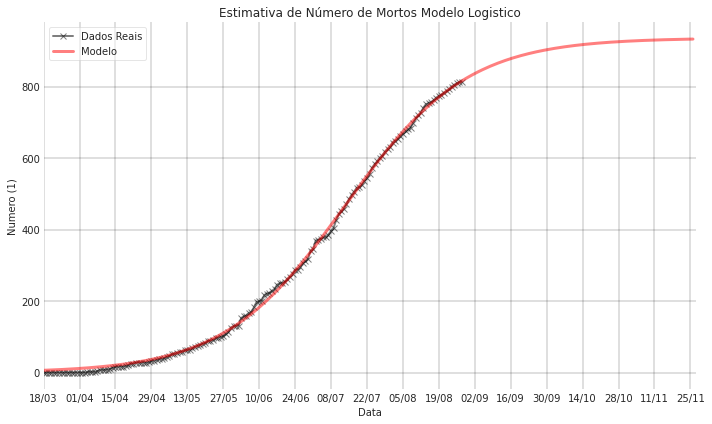

In [27]:
lbounds = [0, 0, 0]
gbounds = [np.inf, np.inf, np.inf]
guess = [1, 1, 1]
data_series = df_jp['deaths']
model_param = fit(data_series,  logistic_model, lbounds, gbounds, guess)
a=model_param[0]
b=model_param[1]
c=model_param[2]
print('Parâmetros Modelo Logistico Mortos','a=',a ,'b=',b,'c=',c)

number_days_future = 90
plot_chart_model(data_series,logistic_model,model_param,number_days_future,'Estimativa de Número de Mortos Modelo Logistico')

Parâmetros Modelo Logistico Confirmados a= 19.629919136752527 b= 106.42913574421233 c= 26875.663326422513


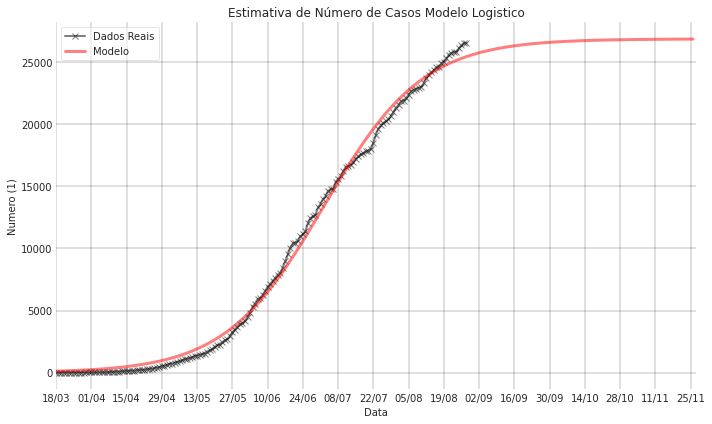

In [28]:
lbounds = [0, 0, 0]
gbounds = [np.inf, np.inf, np.inf]
guess = [1, 1, 1]
data_series = df_jp['confirmed_cases']
model_param = fit(data_series,  logistic_model, lbounds, gbounds, guess)
a=model_param[0]
b=model_param[1]
c=model_param[2]
print('Parâmetros Modelo Logistico Confirmados','a=',a ,'b=',b,'c=',c)
number_days_future = 90
plot_chart_model(data_series,logistic_model,model_param,number_days_future,'Estimativa de Número de Casos Modelo Logistico')

Parâmetros Modelo SIR initial_infected= 2.0016375472891745 beta= 0.16843042229389477 gamma= 7.635248052241161 population= 218828.3077950358 t0= -139.366946061391


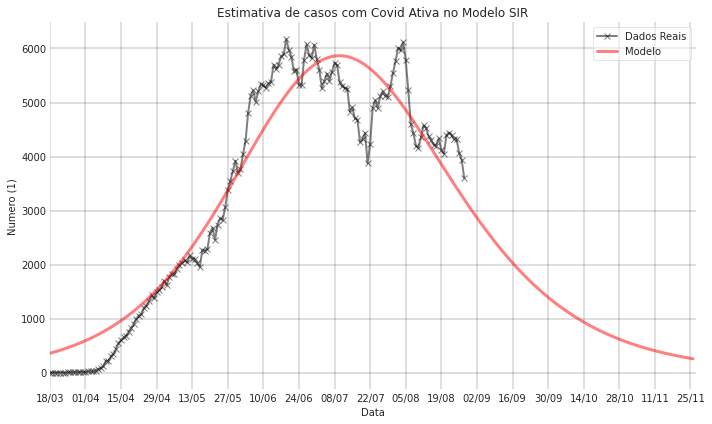

In [29]:
# Fit the SIR Model
"""
        - initial_infected : (float) SIR Model I0 parameter. Initial infected subjects
        - beta : (float) Transmission rate
        - gamma : (float) Typical time between contacts
        - population : (float) Susceptible population
        - t0 : (float) Initial time to fix origin
"""

lbounds = [0, 0, 1, 0, -np.inf]
gbounds = [np.inf, np.inf, np.inf, np.inf, np.inf]
guess = [1, 1, 50, 3.5e6, 0]
data_series = df_jp['active_cases']
model_param = fit(data_series,  sir_model, lbounds, gbounds, guess)
initial_infected=model_param[0]
beta=model_param[1]
gamma=model_param[2]
population=model_param[3]
t0=model_param[4]
print('Parâmetros Modelo SIR','initial_infected=',initial_infected ,'beta=',beta,'gamma=',gamma,'population=',population, 't0=',t0)
number_days_future = 90
plot_chart_model(data_series,sir_model,model_param,number_days_future,'Estimativa de casos com Covid Ativa no Modelo SIR')

In [30]:
def sir_model_confirmed(x, initial_infected, beta, gamma, population, t0, initial_recovered=0, tmax=365, n=500):

    """"Uses SIR Model (https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model)
        to return the value of the Infected plus recovered Curve at time x, given the SIR Model parameters.

        Parameters:
        - x : (float) Time to evaluate the infected curve
        - initial_infected : (float) SIR Model I0 parameter. Initial infected subjects
        - beta : (float)   infection (or contact) rate 
        - gamma : (float)  recovery rate
        - population : (float) Susceptible population
        - t0 : (float) Initial time to fix origin
        - initial_recovered : (float) Initial recovered individuals (Default 0)
        - tmax : (float) Time for integrating the differential equations, in days (Default 365)
        - n : (int) Number of time points for integrating the differential equations (Default 1000)"""

    
    initial_susceptible = population - initial_infected - initial_recovered  # Everyone who is susceptible to infection
    t = np.linspace(t0, tmax, n)  # Time vector for integrating

    def derivatives(y, _):

        """SIR Model Differential Equations

            Parameters:
            - y : (np.ndarray) Array containing [Susceptible, Infected, Recovered] points
            - _ : (None) Empty parameter for consistency with scipy.integrate.odeint method"""

        s, i, _ = y
        derivative_a = -beta * s * i / population  # dS/dt
        derivative_b = beta * s * i / population - gamma * i  # dI/dt
        derivative_c = gamma * i  # dR / dt
        return derivative_a, derivative_b, derivative_c

    y0 = initial_susceptible, initial_infected, initial_recovered  # Initial conditions vector
    sol = integrate.odeint(derivatives, y0, t)  # Integrate the SIR equations over the time grid, total_time
    
    infected = sol[:, 1]  # Infected individuals for each day
    interp = interpolate.interp1d(t, infected, fill_value='extrapolate')  # Creates an interpolator with the vectors
    infected_interpolated =  interp(x)
    
    recovered = sol[:, 2]  # recoverd individuals
    interp = interpolate.interp1d(t, recovered, fill_value='extrapolate')  # Creates an interpolator with the vectors
    recovered_interpolated =  interp(x)
    
    infected_plus_recovered = infected_interpolated + recovered_interpolated
    #print('sir model','initial_infected=',initial_infected, 'beta=',beta , 'gamma=',gamma , 'population=',population,)
    #raise Exception("Stop Script") 
    #%debug
    return infected_plus_recovered

Parâmetros Modelo SIR initial_infected= 10.816283569773205 beta= 1.2812739251227214 gamma= 1.2399237038076587 r_0= 1.033349004610591 population= 2983099.5090742623 t0= -34.70420453638866


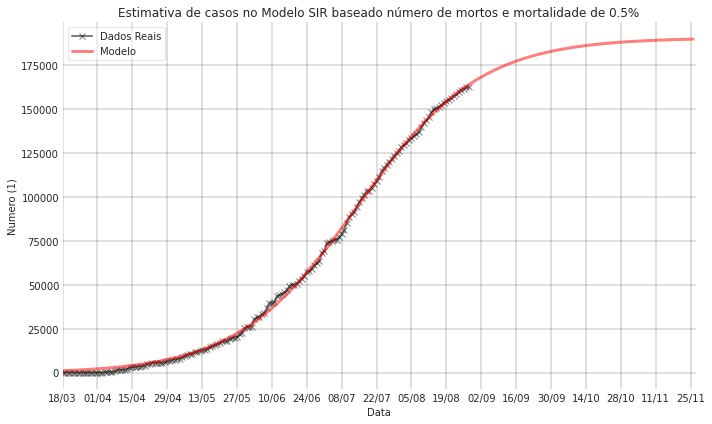

In [31]:
# Fit the SIR Model based on deaths
"""
        - initial_infected : (float) SIR Model I0 parameter. Initial infected subjects
        - beta : (float)   infection (or contact) rate 
        - gamma : (float)  recovery rate
        - population : (float) Susceptible population
        - t0 : (float) Initial time to fix origin
"""

lbounds = [0, 0, 0, 0, -100]
gbounds = [np.inf, np.inf, np.inf, 13e6, np.inf]
guess = [1, 1, 1, 3e6, -20]
data_series = df_jp['deaths']/(0.005)
model_param = fit(data_series,  sir_model_confirmed, lbounds, gbounds, guess)
initial_infected=model_param[0]
beta=model_param[1]
gamma=model_param[2]
population=model_param[3]
t0=model_param[4]
r_0=beta/gamma
print('Parâmetros Modelo SIR','initial_infected=',initial_infected ,'beta=',beta,'gamma=',gamma, 'r_0=', r_0, 'population=',population, 't0=',t0)
number_days_future = 90
plot_chart_model(data_series,sir_model_confirmed,model_param,number_days_future,'Estimativa de casos no Modelo SIR baseado número de mortos e mortalidade de 0.5%')

In [32]:
def plot_chart(df, column_name, chart_title):
  """Mostra gráfico de barras 
  Args:
        df (Dataframe): Dados do Dataframe do arquivo CSV.
        column_name (str): nome da coluna do dataframe com os dados.
        chart_title (str): Título do Gráfico.
  """
    
  
  #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html#pandas.DataFrame.plot
  #ax = df[column_name].plot(kind='bar', figsize=(10,5), title=chart_title, grid=True);
  #https://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes
  #ax.set_xticklabels([temp.strftime("%m-%d") for temp in df.index]);
    
  #https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/  
  fig, ax = plt.subplots(figsize=(14, 8));
    
    
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m (%U)'))
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
  fig.autofmt_xdate()  
    
  ax.grid(zorder=0)
  # Add x-axis and y-axis
  ax.bar(df.index.values,
        df[column_name],
        color='blue');
  # Set title and labels for axes
  ax.set(xlabel="Data",
       title=chart_title);
  # Rotate tick marks on x-axis
  plt.setp(ax.get_xticklabels(), rotation=90)
  plt.show()

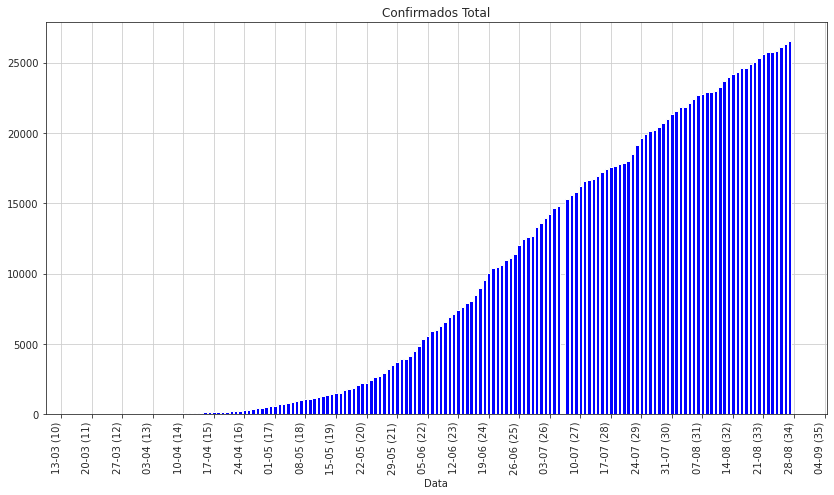

In [33]:
plot_chart(df_jp,'confirmed_cases','Confirmados Total')

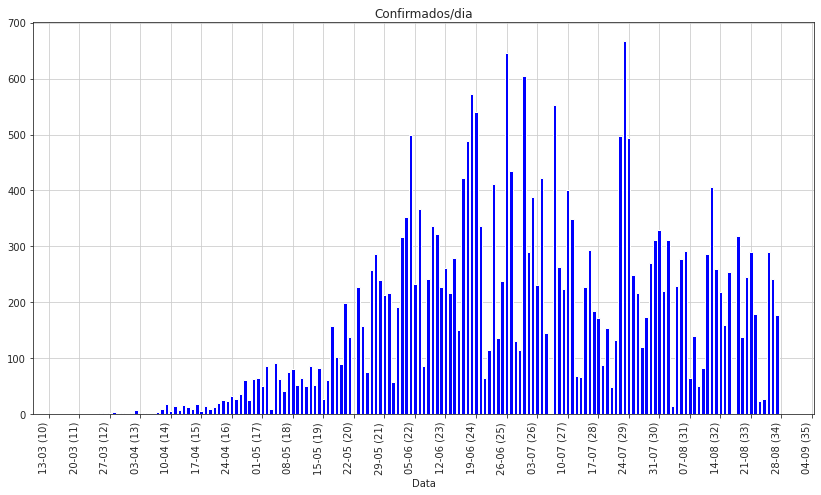

In [34]:
plot_chart(df_jp,'daily_cases','Confirmados/dia')

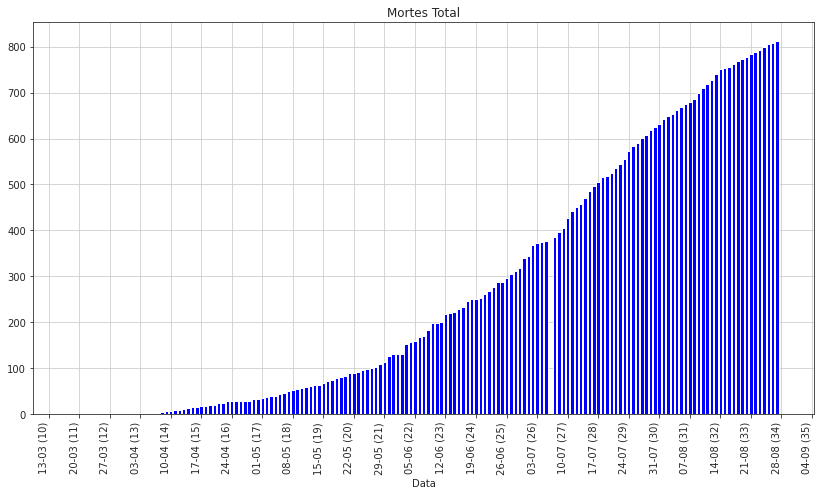

In [35]:
plot_chart(df_jp,'deaths','Mortes Total')

Subnotificação 

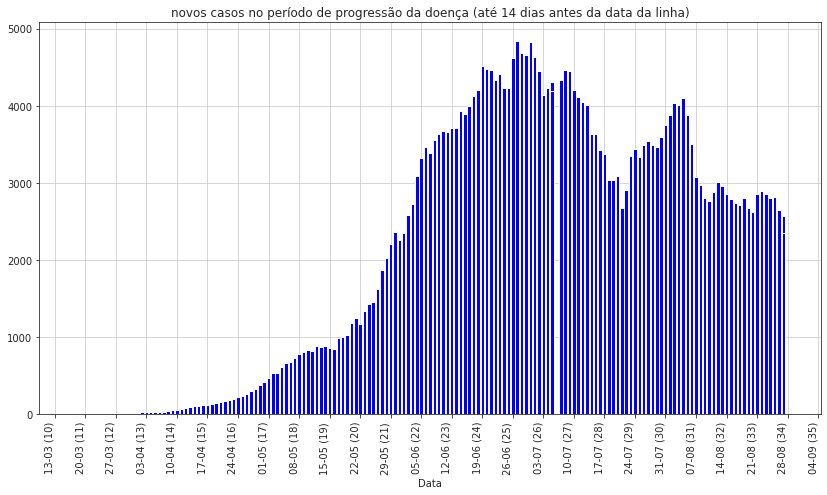

In [36]:
plot_chart(df_jp,'infectious_period_cases','novos casos no período de progressão da doença (até 14 dias antes da data da linha)')


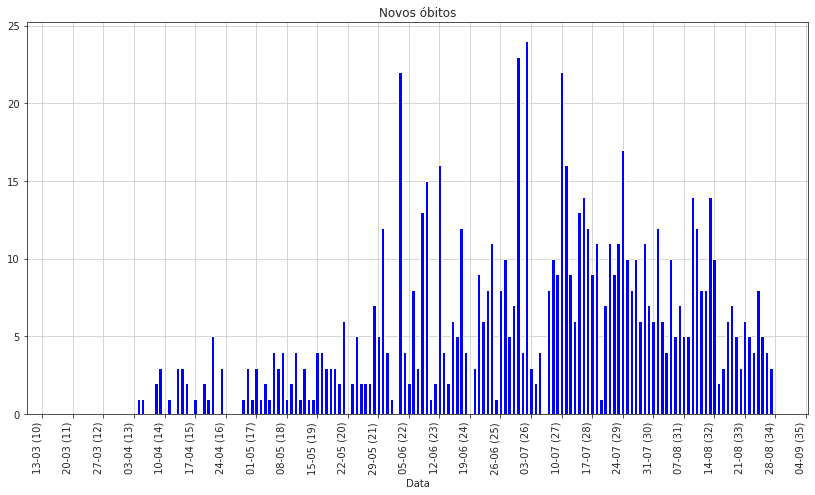

In [37]:
plot_chart(df_jp,'new_deaths','Novos óbitos')

<AxesSubplot:>

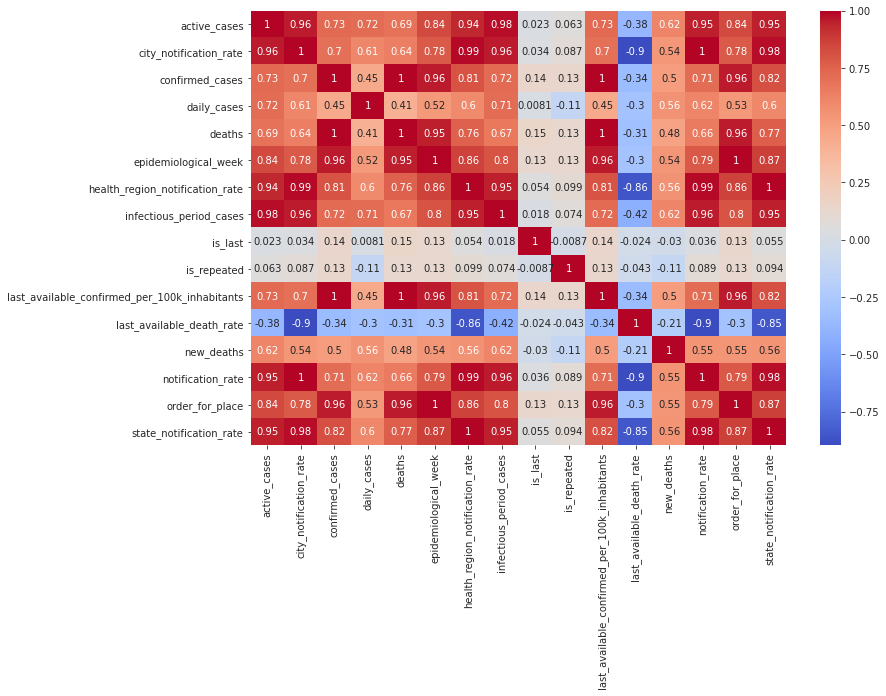

In [38]:
sns.heatmap(df_jp.corr(),annot = True,cmap="coolwarm",fmt='.2g')

In [39]:
def corr_to_target(dataframe, target, title=None):
    """
    Apresenta heatmap apenas do nosso target com as demais features
    
    :param dataframe: dataframe contendo features e target
    :param target: nome da coluna do target
    :param title: título do nosso gráfico
    """
    plt.figure(figsize=(4, 10))
    sns.heatmap(dataframe.corr()[[target]].sort_values(target, ascending=False)[1:], 
                annot=True, 
                fmt='.2f',
                cmap='coolwarm')
    
    if title:
        plt.title(f'\n{title}\n', fontsize=18)
    
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

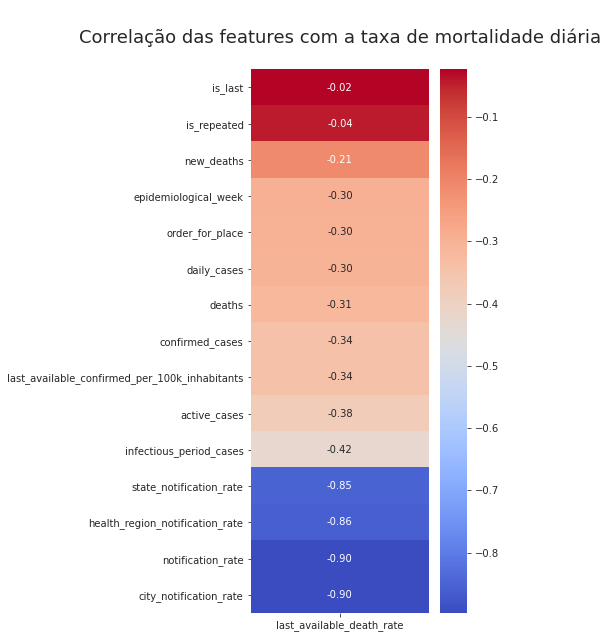

In [40]:
corr_to_target(df_jp,'last_available_death_rate' , title='Correlação das features com a taxa de mortalidade diária')

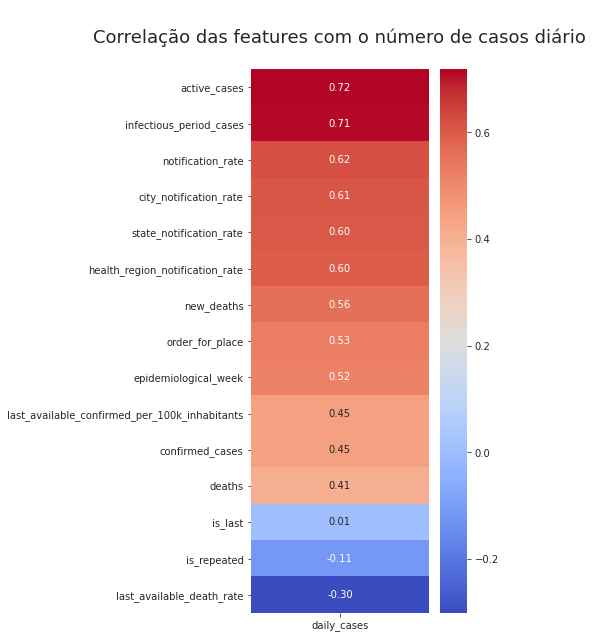

In [48]:
# daily_cases

corr_to_target(df_jp,'daily_cases', title='Correlação das features com o número de casos diário')

<img src ="data/Kurtosis.jpg">

O número de casos diários possui uma forte correlação com o número de novos casos no período de progressão da doença, o que reforça a necessidade de isolamento social para que possamos achatar a curva de contágio, ou seja, a curva de casos ativos com covid precisa passar do estágio leptocúrtica para o estágio platicúrtica, para que então o sistema de saúde possa lidar com os enfermos sem colapsar

O heartmap mostrando a correlação entre as variáveis nos mostra dados interessantes como que a taxa de mortalidade do último dia possui uma correlação inversa quase que perfeita (-0.9) com a Taxa de notificação de casos estimada no município.
  Através do gráfico abaixo é possível observar que principalmente entre o mês 4 e o mês 5, João Pessoa possuiu uma alta taxa de mortalidade, o que foi noticiado em cadeia nacional, como no [link](https://g1.globo.com/pb/paraiba/noticia/2020/04/16/paraiba-e-o-estado-com-maior-taxa-de-letalidade-por-covid-19-no-pais-segundo-ms.ghtml), matéria publicada em 16/04/2020, o que pode acusar uma subnotificação provavelmente por baixa testagem da população, o que pode influenciar no número total de casos e de mortes por COVID-19.

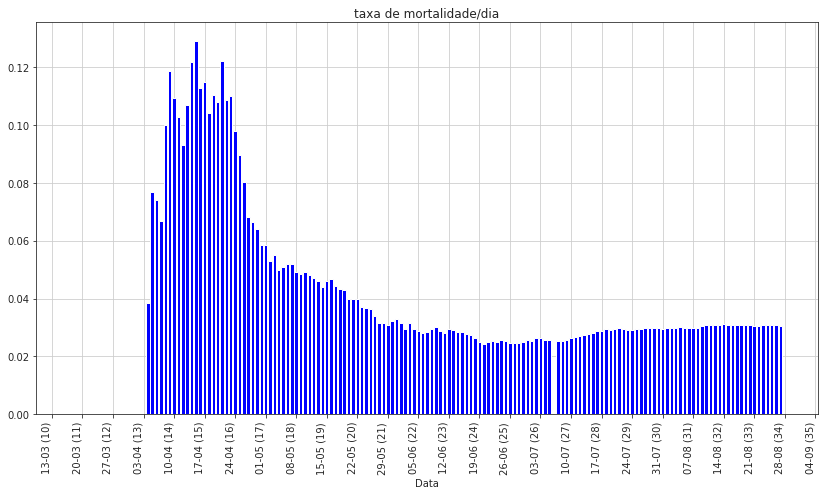

In [41]:
plot_chart(df_jp,'last_available_death_rate','taxa de mortalidade/dia')

In [42]:
df_jp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 164 entries, 2020-03-18 to 2020-08-27
Data columns (total 19 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   active_cases                                   164 non-null    float64
 1   city_notification_rate                         141 non-null    float64
 2   confirmed_cases                                164 non-null    float64
 3   daily_cases                                    164 non-null    float64
 4   deaths                                         164 non-null    float64
 5   epidemiological_week                           164 non-null    int64  
 6   health_region_notification_place_type          145 non-null    object 
 7   health_region_notification_rate                145 non-null    float64
 8   infectious_period_cases                        164 non-null    float64
 9   is_last                            

In [43]:
trace_cont = go.Scatter(
             x= df_jp.index,
             y=df_jp.confirmed_cases,
             name = 'confirmed_cases',
             line = dict(color='#17BECF'),
             opacity = 0.8
)


trace_death= go.Scatter(
             x= df_jp.index,
             y=df_jp.deaths,
             name = 'deaths',
             line = dict(color='#B22222'),
             opacity = 0.8
                      )




data = [trace_cont,trace_death]

layout = dict (
          title = 'Avanço do COVID-19 em João Pessoa, total de contaminados e mortes. '
               )
fig = dict (data=data,layout=layout)

iplot(fig, filename = 'dados_covid')

In [44]:
trace_new_cont = go.Scatter(
             x= df_jp.index,
             y=df_jp.daily_cases,
             name = 'novos casos confirmados ',
             line = dict(color='#17BECF'),
             opacity = 0.8
)


trace_new_death= go.Scatter(
             x= df_jp.index,
             y=df_jp.new_deaths,
             name = 'novos óbitos',
             line = dict(color='#B22222'),
             opacity = 0.8
                      )



trace_infectious_period_= go.Scatter(
             x= df_jp.index,
             y=df_jp.infectious_period_cases,
             name = 'Número de novos casos no período de progressão da doença',
             line = dict(color='#B22222'),
             opacity = 0.8
                      )

data = [trace_new_cont,trace_new_death]

layout = dict (
          title = 'Avanço do COVID-19 em João Pessoa, total de contaminados e mortes. '
               )
fig = dict (data=data,layout=layout)

iplot(fig, filename = 'dados_covid')